In [48]:
# Import the necessary packages
#Third Party Packages
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import *
#from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.ensemble import GradientBoostingRegressor


!pip install chempy
from chempy import Substance
from chempy.kinetics.ode import get_odesys
from chempy.kinetics.rates import MassAction

# Set seaborn style for better visualizations
sns.set(style="whitegrid")

# Define the SRM color mapping with the specified colors
srm_colors_custom = {
    1: "#f7e1a1",
    3: "#e9ad3f",
    5: "#d98416",
    9: "#b74d00",
    12: "#9f3400",
    16: "#811f00",
    22: "#5e0e00",
    29: "#410500",
    35: "#2f0200",
    65: "#0d0000"
}

# Convert the dictionary to a list of tuples (SRM value, color)
srm_color_list_custom = [(srm, color) for srm, color in srm_colors_custom.items()]

# Create a colormap from the SRM color list
srm_cmap_custom = mcolors.LinearSegmentedColormap.from_list("srm_cmap_custom", srm_color_list_custom)

# Register the colormap with matplotlib
plt.register_cmap(cmap=srm_cmap_custom)

In [2]:
# Create DataFrame
beer_df = pd.read_csv("Data/brewery_data_complete_extended.csv")
# Display
print("Total number of results:", len(beer_df))
display(beer_df.head()) # Using display instead of print leads to a

Total number of results: 10000000


,Batch_ID,Brew_Date,Beer_Style,SKU,Location,Fermentation_Time,Temperature,pH_Level,Gravity,Alcohol_Content,Bitterness,Color,Ingredient_Ratio,Volume_Produced,Total_Sales,Quality_Score,Brewhouse_Efficiency,Loss_During_Brewing,Loss_During_Fermentation,Loss_During_Bottling_Kegging
0,7870796,2020-01-01 00:00:19,Wheat Beer,Kegs,Whitefield,16,24.204251,5.289845,1.039504,5.370842,20,5,1:0.32:0.16,4666,2664.759345,8.577016,89.195882,4.104988,3.235485,4.663204
1,9810411,2020-01-01 00:00:31,Sour,Kegs,Whitefield,13,18.086763,5.275643,1.059819,5.096053,36,14,1:0.39:0.24,832,9758.801062,7.420541,72.480915,2.676528,4.246129,2.044358
2,2623342,2020-01-01 00:00:40,Wheat Beer,Kegs,Malleswaram,12,15.539333,4.778016,1.037476,4.824737,30,10,1:0.35:0.16,2115,11721.087016,8.451365,86.322144,3.299894,3.109440,3.033880
3,8114651,2020-01-01 00:01:37,Ale,Kegs,Rajajinagar,17,16.418489,5.345261,1.052431,5.509243,48,18,1:0.35:0.15,3173,12050.177463,9.671859,83.094940,2.136055,4.634254,1.489889
4,4579587,2020-01-01 00:01:43,Stout,Cans,Marathahalli,18,19.144908,4.861854,1.054296,5.133625,57,13,1:0.46:0.11,4449,5515.077465,7.895334,88.625833,4.491724,2.183389,2.990630


In [3]:
# Get summary
display(beer_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 20 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Batch_ID                      int64  
 1   Brew_Date                     object 
 2   Beer_Style                    object 
 3   SKU                           object 
 4   Location                      object 
 5   Fermentation_Time             int64  
 6   Temperature                   float64
 7   pH_Level                      float64
 8   Gravity                       float64
 9   Alcohol_Content               float64
 10  Bitterness                    int64  
 11  Color                         int64  
 12  Ingredient_Ratio              object 
 13  Volume_Produced               int64  
 14  Total_Sales                   float64
 15  Quality_Score                 float64
 16  Brewhouse_Efficiency          float64
 17  Loss_During_Brewing           float64
 18  Loss_During_Fermentat

None

In [4]:
# Create a copy of the DataFrame to avoid altering the original
beer_copy = beer_df.copy()

In [5]:
beer_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Batch_ID,10000000.0,5.000000e+06,2.886751e+06,0.000000,2.500000e+06,5.000000e+06,7.499999e+06,9.999999e+06
Fermentation_Time,10000000.0,1.450090e+01,2.872006e+00,10.000000,1.200000e+01,1.500000e+01,1.700000e+01,1.900000e+01
Temperature,10000000.0,1.999990e+01,2.887030e+00,15.000001,1.749984e+01,1.999977e+01,2.250076e+01,2.500000e+01
pH_Level,10000000.0,4.999941e+00,2.886376e-01,4.500000,4.750040e+00,4.999885e+00,5.249937e+00,5.500000e+00
Gravity,10000000.0,1.055003e+00,1.443465e-02,1.030000,1.042502e+00,1.055004e+00,1.067505e+00,1.080000e+00
Alcohol_Content,10000000.0,5.249709e+00,4.329614e-01,4.500000,4.874663e+00,5.249849e+00,5.624602e+00,6.000000e+00
Bitterness,10000000.0,3.949620e+01,1.154557e+01,20.000000,2.900000e+01,3.900000e+01,4.900000e+01,5.900000e+01
Color,10000000.0,1.199935e+01,4.321170e+00,5.000000,8.000000e+00,1.200000e+01,1.600000e+01,1.900000e+01
Volume_Produced,10000000.0,2.749031e+03,1.299078e+03,500.000000,1.623000e+03,2.749000e+03,3.874000e+03,4.999000e+03
Total_Sales,10000000.0,1.049779e+04,5.485996e+03,1000.000963,5.747244e+03,1.049629e+04,1.524921e+04,2.000000e+04


In [53]:
# Sample 2.5% of the rows with a seed for reproducibility
beer_sample = beer_copy.sample(frac=0.025, random_state=42)

# Export the subsample as a .csv file
beer_sample.to_csv('beer_sample.csv', index=False)

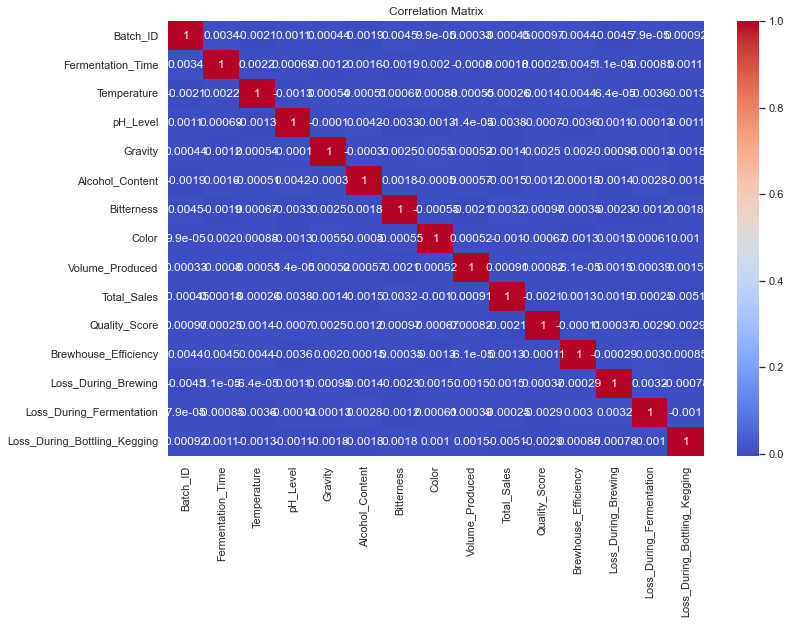

In [7]:
# Compute the correlation matrix
corr_matrix = beer_sample.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


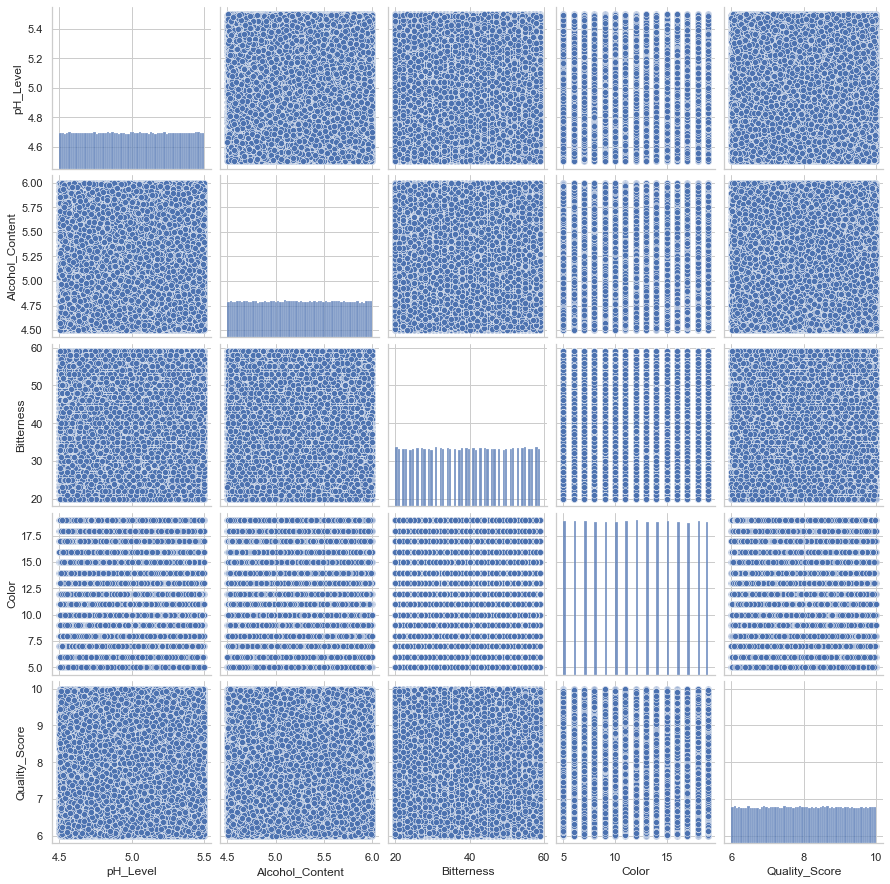

In [8]:
# Select relevant numerical columns for the pair plot
# Adjust the column names 
numeric_columns = ['pH_Level', 'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']

# Plot the pair plot
sns.pairplot(beer_sample[numeric_columns])
plt.show()

In [9]:
# Define the columns relevant for feature engineering (features that contain chemistry dependent properties)
relevant_columns = ['pH_Level', 'Ingredient_Ratio', 'Fermentation_Time', 'Temperature', 
                    'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']
categorical_columns = ['Beer_Style']

# Create a subset of the data with relevant columns
beer_quality_predict = beer_sample[relevant_columns + categorical_columns].copy()

# Preview the subset of the data
print("Subset of the data with relevant columns:")
display(beer_quality_predict.head())


Subset of the data with relevant columns:


,pH_Level,Ingredient_Ratio,Fermentation_Time,Temperature,Alcohol_Content,Bitterness,Color,Quality_Score,Beer_Style
919213,4.944504,1:0.26:0.17,15,15.070090,5.104899,20,19,6.366748,Stout
9467153,5.403599,1:0.31:0.10,19,15.563835,5.075242,57,14,6.895413,Wheat Beer
6585777,4.660539,1:0.32:0.21,18,17.472288,4.864122,20,9,6.964137,Sour
3878022,4.771273,1:0.32:0.24,14,19.652672,5.831239,20,19,6.683244,Ale
5537116,5.377406,1:0.30:0.16,12,16.052576,5.343178,37,17,6.955717,Porter


In [10]:
beer_quality_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 919213 to 8435168
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pH_Level           250000 non-null  float64
 1   Ingredient_Ratio   250000 non-null  object 
 2   Fermentation_Time  250000 non-null  int64  
 3   Temperature        250000 non-null  float64
 4   Alcohol_Content    250000 non-null  float64
 5   Bitterness         250000 non-null  int64  
 6   Color              250000 non-null  int64  
 7   Quality_Score      250000 non-null  float64
 8   Beer_Style         250000 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 29.1+ MB


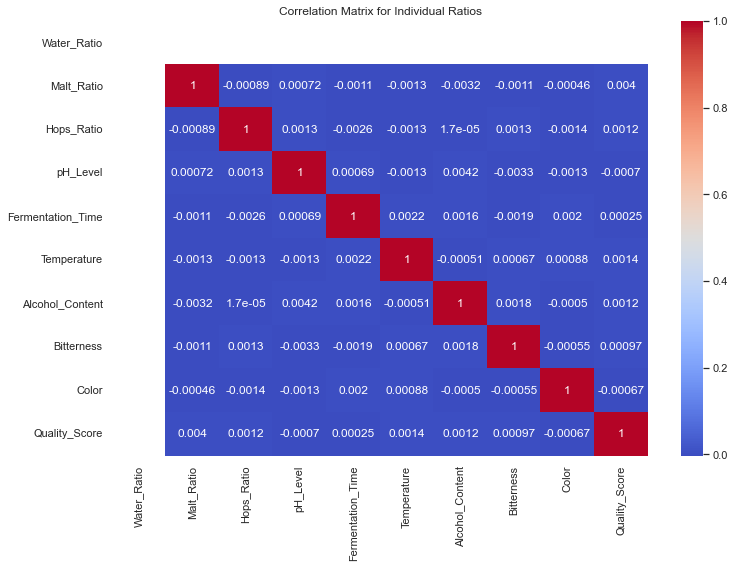

In [11]:
#Extract Individual Components
beer_quality_predict['Water_Ratio'] = 1.0
beer_quality_predict['Malt_Ratio'] = beer_quality_predict['Ingredient_Ratio'].apply(lambda x: float(x.split(':')[1]))
beer_quality_predict['Hops_Ratio'] = beer_quality_predict['Ingredient_Ratio'].apply(lambda x: float(x.split(':')[2]))

#Calculate Correlations:
correlation_matrix_indv = beer_quality_predict[['Water_Ratio', 'Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature', 
                                'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']].corr()

#Visualize Correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_indv, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Individual Ratios')
plt.show()


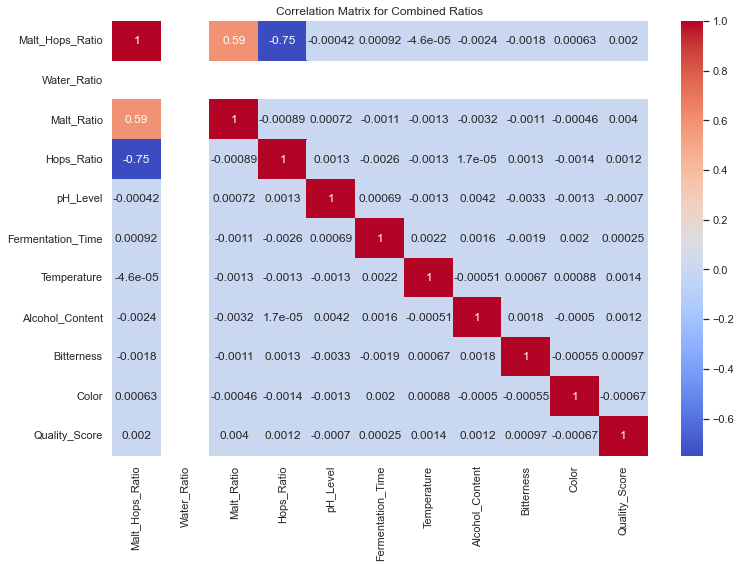

In [12]:
#Create Combined Ratio Feature
beer_quality_predict['Malt_Hops_Ratio'] = beer_quality_predict['Malt_Ratio'] / beer_quality_predict['Hops_Ratio']

#Calculate Correlations
combined_corr_matrix = beer_quality_predict[['Malt_Hops_Ratio','Water_Ratio', 'Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature', 
                                'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']].corr()

#Visualize Correlations
plt.figure(figsize=(12, 8))
sns.heatmap(combined_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Combined Ratios')
plt.show()

In [13]:
# Function to infer malt type from color
def infer_malt(color):
    """
    Infers the type of malt based on the color of the beer.
    """
    if color < 10:
        return 'Barley'
    elif color < 20:
        return 'Wheat'
    elif color < 30:
        return 'Rye'
    else:
        return 'Oats'

# Function to infer hops type from bitterness
def infer_hops(bitterness):
    """
    Infers the type of hops based on the bitterness of the beer.
    """
    if bitterness > 40:
        return 'Bittering'
    elif bitterness > 20:
        return 'Dual Purpose'
    else:
        return 'Aroma'

#leaving out yeast because the traditional classification of ales and lagers doesn't fit well
#with my data
# Function to infer yeast type from temperature
#def infer_yeast(temperature):
#    """
#    Infers the type of yeast based on the fermentation temperature in Celsius.
#    """
#    if temperature > 15:
#        return 'Lager'
#    else:
#        return 'Ale'

# Apply feature engineering functions to infer malt, hops, and yeast types
beer_quality_predict['Malt_Type'] = beer_quality_predict['Color'].apply(infer_malt)
beer_quality_predict['Hops_Type'] = beer_quality_predict['Bitterness'].apply(infer_hops)
#beer_quality_predict['Yeast_Type'] = beer_quality_predict['Temperature'].apply(infer_yeast)

# Preview the engineered features
print("Data with engineered features (Malt_Type, Hops_Type):")
display(beer_quality_predict.head())

#Ales: 62-75 °F (17-24 °C)
#Lagers: 46-58 °F (8-14 °C) #assume dark lagers in this project
#Wheat and Belgian styles: 62-85 °F (17-29 °C), ales divided into these categories


Data with engineered features (Malt_Type, Hops_Type):


,pH_Level,Ingredient_Ratio,Fermentation_Time,Temperature,Alcohol_Content,Bitterness,Color,Quality_Score,Beer_Style,Water_Ratio,Malt_Ratio,Hops_Ratio,Malt_Hops_Ratio,Malt_Type,Hops_Type
919213,4.944504,1:0.26:0.17,15,15.070090,5.104899,20,19,6.366748,Stout,1.0,0.26,0.17,1.529412,Wheat,Aroma
9467153,5.403599,1:0.31:0.10,19,15.563835,5.075242,57,14,6.895413,Wheat Beer,1.0,0.31,0.10,3.100000,Wheat,Bittering
6585777,4.660539,1:0.32:0.21,18,17.472288,4.864122,20,9,6.964137,Sour,1.0,0.32,0.21,1.523810,Barley,Aroma
3878022,4.771273,1:0.32:0.24,14,19.652672,5.831239,20,19,6.683244,Ale,1.0,0.32,0.24,1.333333,Wheat,Aroma
5537116,5.377406,1:0.30:0.16,12,16.052576,5.343178,37,17,6.955717,Porter,1.0,0.30,0.16,1.875000,Wheat,Dual Purpose


In [14]:
# Create 3 quantile-based bins for the Temperature column
beer_quality_predict['Temperature_Bins'] = pd.qcut(beer_quality_predict['Temperature'], q=3)

# Get the value counts for each bin
temperature_bin_counts = beer_quality_predict['Temperature_Bins'].value_counts().sort_index()

# Display the bins and their counts
print("Temperature Data Ranges with Counts:")
print(temperature_bin_counts)



Temperature Data Ranges with Counts:
(14.999, 18.338]    83334
(18.338, 21.671]    83333
(21.671, 25.0]      83333
Name: Temperature_Bins, dtype: int64


reasonable considering thermometer calibration, elevation, and any other scientific explanation for slightly different temperatures.

In [15]:
beer_quality_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 919213 to 8435168
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   pH_Level           250000 non-null  float64 
 1   Ingredient_Ratio   250000 non-null  object  
 2   Fermentation_Time  250000 non-null  int64   
 3   Temperature        250000 non-null  float64 
 4   Alcohol_Content    250000 non-null  float64 
 5   Bitterness         250000 non-null  int64   
 6   Color              250000 non-null  int64   
 7   Quality_Score      250000 non-null  float64 
 8   Beer_Style         250000 non-null  object  
 9   Water_Ratio        250000 non-null  float64 
 10  Malt_Ratio         250000 non-null  float64 
 11  Hops_Ratio         250000 non-null  float64 
 12  Malt_Hops_Ratio    250000 non-null  float64 
 13  Malt_Type          250000 non-null  object  
 14  Hops_Type          250000 non-null  object  
 15  Temperature_Bins   250000 no

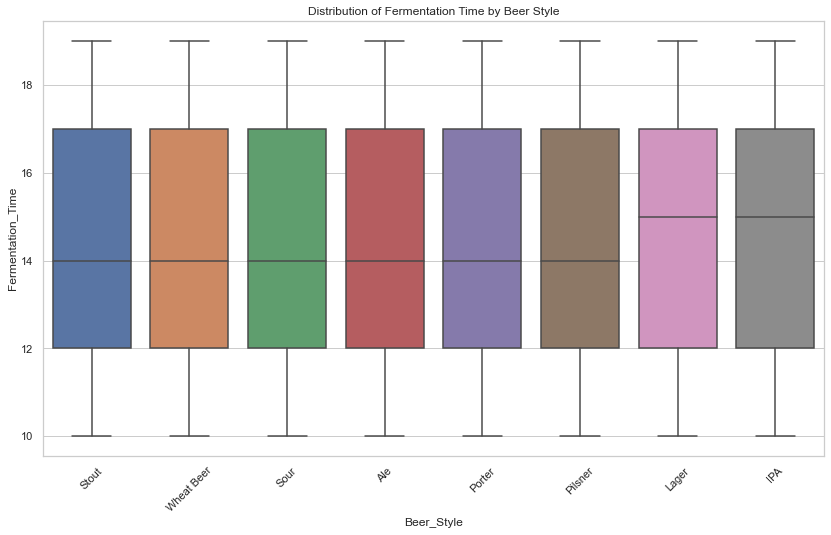

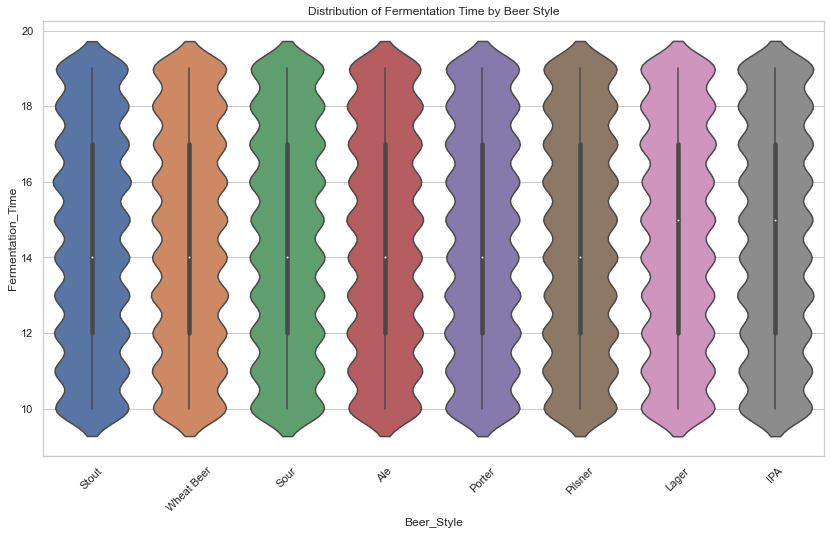

In [16]:
# Does Beer_Style feature distribute consistently into the 
#Fermentation_Time feature?

# Extract relevant columns
ferment_style_comp = beer_quality_predict[['Beer_Style', 'Fermentation_Time']]

# Create a box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Beer_Style', y='Fermentation_Time', data=ferment_style_comp)
plt.title('Distribution of Fermentation Time by Beer Style')
plt.xticks(rotation=45)
plt.show()

# Create a violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='Beer_Style', y='Fermentation_Time', data=ferment_style_comp)
plt.title('Distribution of Fermentation Time by Beer Style')
plt.xticks(rotation=45)
plt.show()

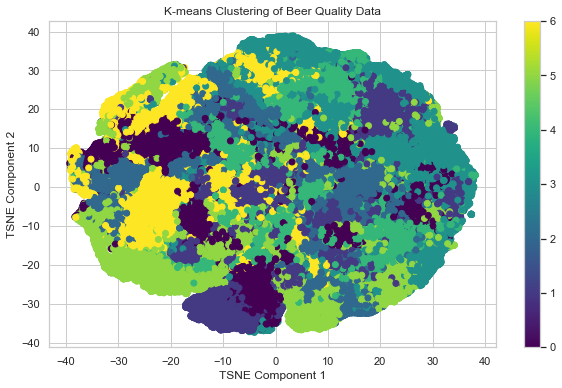

In [17]:
# Select relevant features for clustering
clustering_features = beer_quality_predict[['Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']]

# Normalize the features
clustering_features_normalized = (clustering_features - clustering_features.mean()) / clustering_features.std()

# Apply KMeans clustering
num_clusters = 7  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
beer_quality_predict['Cluster'] = kmeans.fit_predict(clustering_features_normalized)

# Visualize the clusters using t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
clustering_features_tsne = tsne.fit_transform(clustering_features_normalized)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(clustering_features_tsne[:, 0], clustering_features_tsne[:, 1], c=beer_quality_predict['Cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.title('K-means Clustering of Beer Quality Data')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()


In [50]:
# Sample 2.5% of the rows with a seed for reproducibility
test_beer_quality_predict = beer_quality_predict.sample(frac=0.50, random_state=42)

In [51]:
# One-hot encode categorical variables for machine learning models
beer_encoded = pd.get_dummies(test_beer_quality_predict, columns=['Beer_Style', 'Malt_Type', 'Hops_Type'])

# Preview the one-hot encoded dataframe
print("One-hot encoded dataframe:")
display(beer_encoded.head())


One-hot encoded dataframe:


,pH_Level,Ingredient_Ratio,Fermentation_Time,Temperature,Alcohol_Content,Bitterness,Color,Quality_Score,Water_Ratio,Malt_Ratio,...,Beer_Style_Pilsner,Beer_Style_Porter,Beer_Style_Sour,Beer_Style_Stout,Beer_Style_Wheat Beer,Malt_Type_Barley,Malt_Type_Wheat,Hops_Type_Aroma,Hops_Type_Bittering,Hops_Type_Dual Purpose
1198923,4.624166,1:0.33:0.19,18,23.544875,4.851446,45,5,7.438883,1.0,0.33,...,0,0,0,0,0,1,0,0,1,0
1752244,5.088843,1:0.29:0.14,11,23.325096,4.747988,39,11,9.796537,1.0,0.29,...,0,0,0,0,0,0,1,0,0,1
7201729,4.531028,1:0.29:0.25,19,18.303406,4.688581,48,13,8.722669,1.0,0.29,...,0,0,1,0,0,0,1,0,1,0
3920232,5.052222,1:0.28:0.17,10,22.134268,4.600588,25,14,6.916323,1.0,0.28,...,0,0,0,0,0,0,1,0,0,1
6333302,5.123969,1:0.34:0.14,15,20.809025,5.036298,24,13,6.971888,1.0,0.34,...,0,0,0,0,0,0,1,0,0,1


In [52]:
# Select relevant features for clustering
clustering_features = beer_encoded[['Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']]

# Normalize the features
clustering_features_normalized = (clustering_features - clustering_features.mean()) / clustering_features.std()

# Define the range of clusters to test
min_clusters = 1
max_clusters = 30

# Store inertia and silhouette scores for different cluster sizes
inertia_values = []
silhouette_scores = []

# Iterate over the range of clusters
for k in range(min_clusters, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(clustering_features_normalized)
    inertia_values.append(kmeans.inertia_)
    
    # Silhouette score is only defined for k > 1
    if k > 1:
        silhouette_avg = silhouette_score(clustering_features_normalized, cluster_labels)
        silhouette_scores.append(silhouette_avg)

# Plot the inertia values to visualize the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), inertia_values, marker='o', linestyle='-', color='b', label='Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.grid(True)
plt.legend()
plt.show()

# Plot the silhouette scores to further validate the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='-', color='r', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xticks(range(2, max_clusters + 1))
plt.grid(True)
plt.legend()
plt.show()


KeyboardInterrupt: 

Elbow Plot (Inertia):
The elbow plot shows a rapid decrease in inertia up to around 4-6 clusters, beyond which the rate of decrease slows down.
This suggests that a significant amount of the data's variance is captured by around 4-6 clusters.
Silhouette Scores:
The silhouette scores plot shows an upward trend, indicating better-defined clusters as the number of clusters increases.
The highest silhouette scores are observed around 11-14 clusters.
Recommendations:
Increasing Clusters:

Since the silhouette score continues to improve, it may be worth exploring more clusters beyond 20 to see if there is a global maximum.
However, keep in mind that very high numbers of clusters might lead to overfitting where each cluster represents very few data points.
Interpret the Results:

The best practice is to balance between the elbow point in the inertia plot and the silhouette score.
The inertia plot suggests 4-6 clusters as a reasonable range.
The silhouette scores suggest better clustering performance at around 11-14 clusters.
Domain Knowledge:

Use your understanding of the data and its context to decide on the final number of clusters. For example, if the application requires grouping into specific categories, the decision might be guided by practical considerations.
Further Validation:

You can further validate the clusters by examining the cluster centroids and checking if they make sense for your specific application.
Perform additional analysis such as cluster stability tests or cross-validation to confirm the robustness of the clusters.
Next Steps:
Explore More Clusters:

Extend the range of clusters beyond 20 and rerun the analysis to see if silhouette scores stabilize or peak.
Final Decision:

Based on the extended analysis, decide on the optimal number of clusters that balances the inertia and silhouette scores while making practical sense for your application.

tried 30 clusters and global max looks to be at 21

the more clusters used the less we learn. Good cohesive groups but not overfitting. looking for a plateau.

inertia_float
Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided. (similar to a standard deviation)

exponential decay, but leveling off at an asymtote as quickly as expected. 

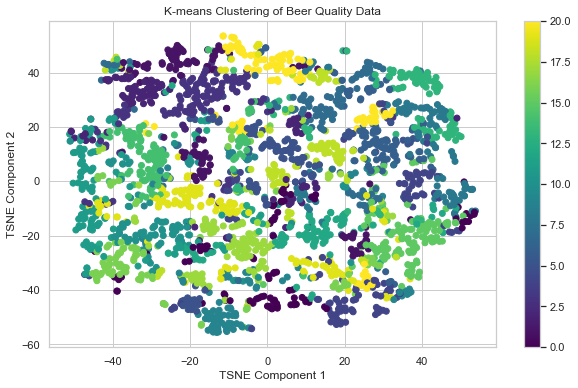

In [22]:
# Apply KMeans clustering
num_clusters = 21  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
beer_encoded['Cluster'] = kmeans.fit_predict(clustering_features_normalized)

# Visualize the clusters using t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
clustering_features_tsne = tsne.fit_transform(clustering_features_normalized)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(clustering_features_tsne[:, 0], clustering_features_tsne[:, 1], c=beer_encoded['Cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.title('K-means Clustering of Beer Quality Data')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.show()


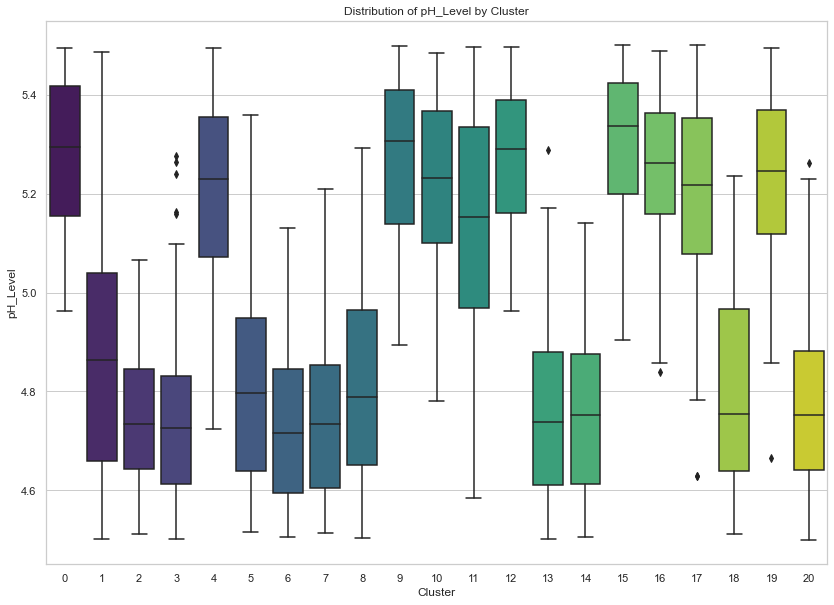

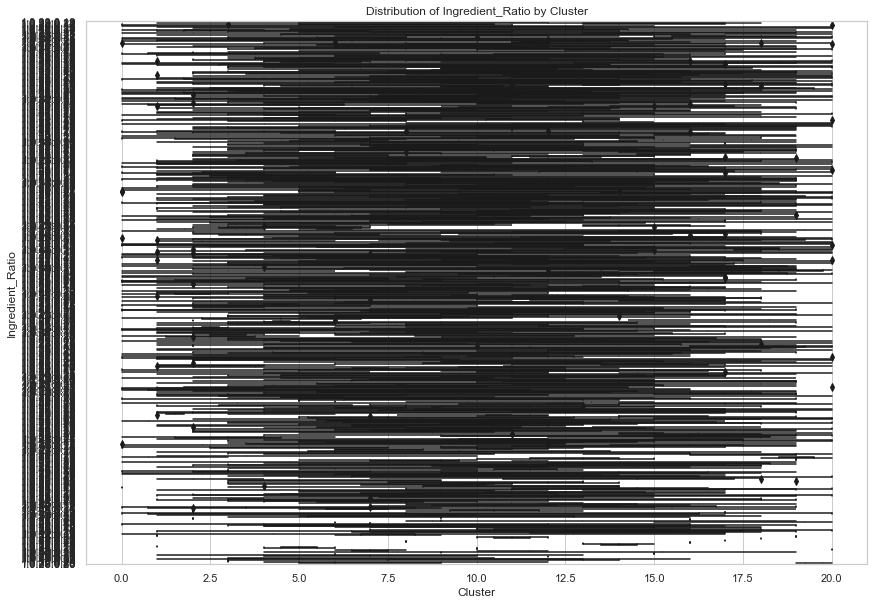

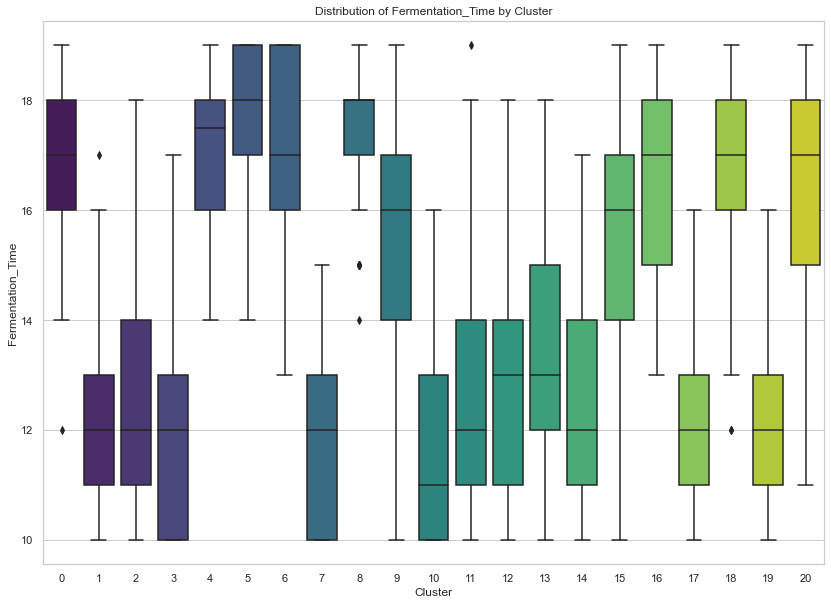

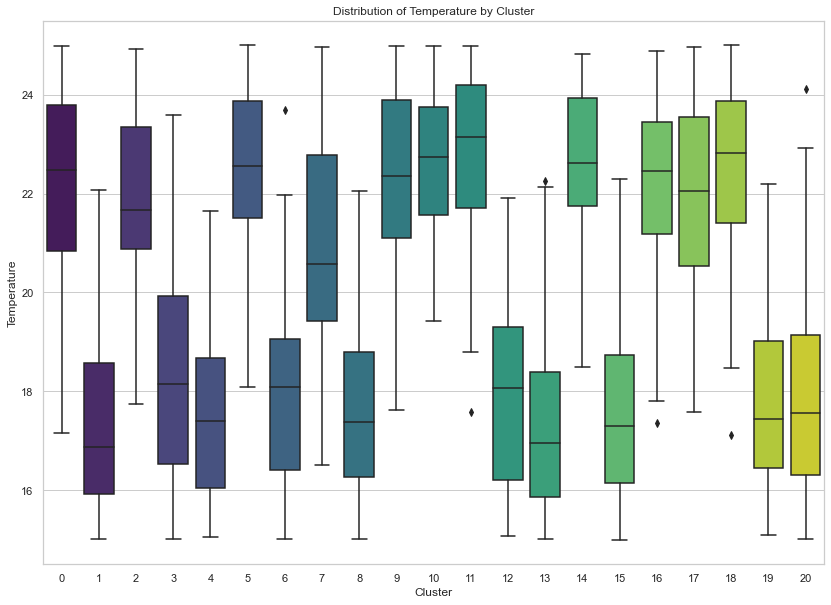

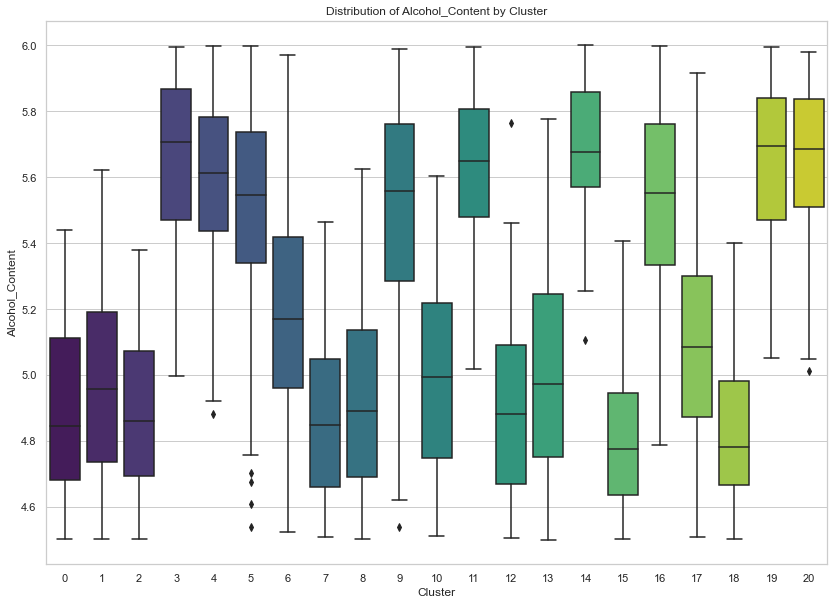

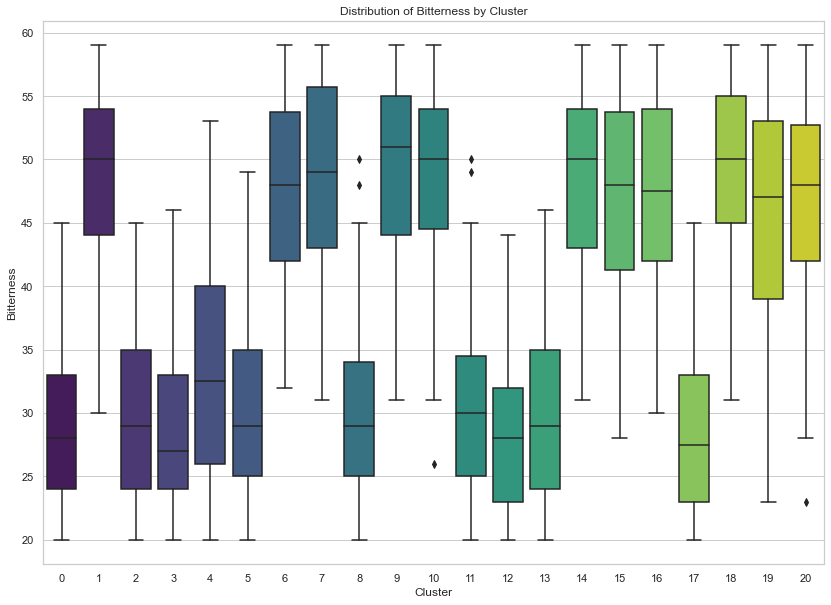

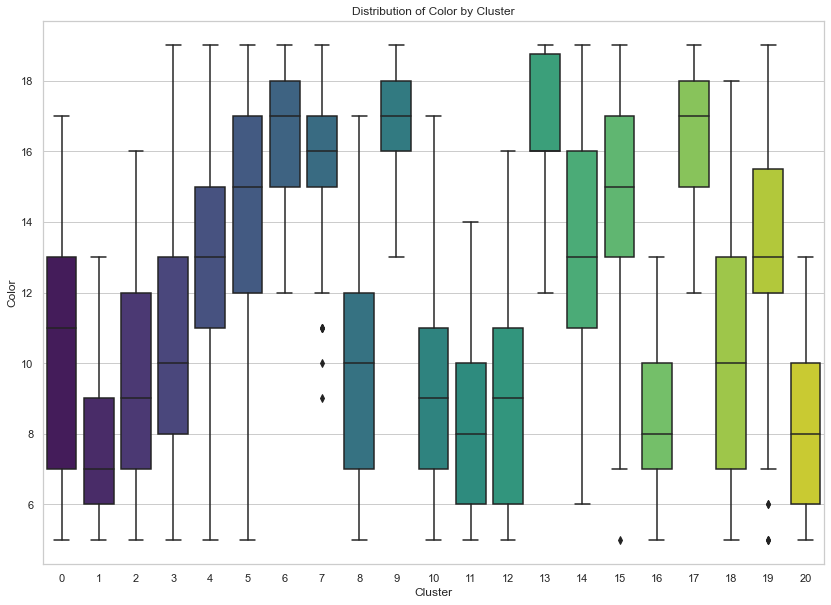

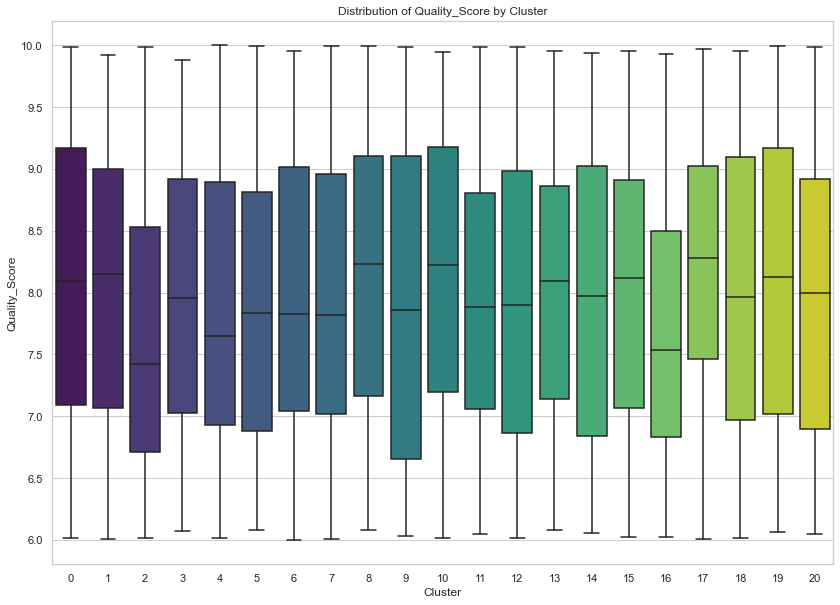

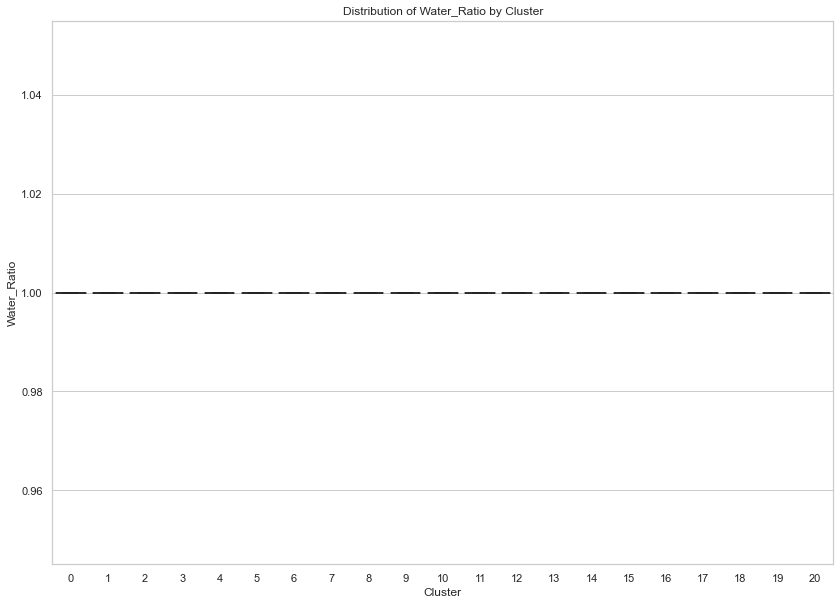

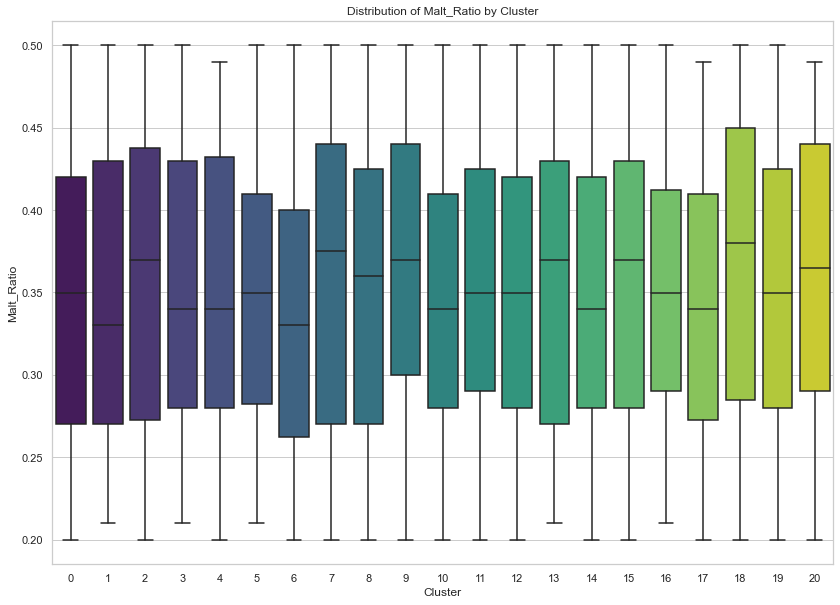

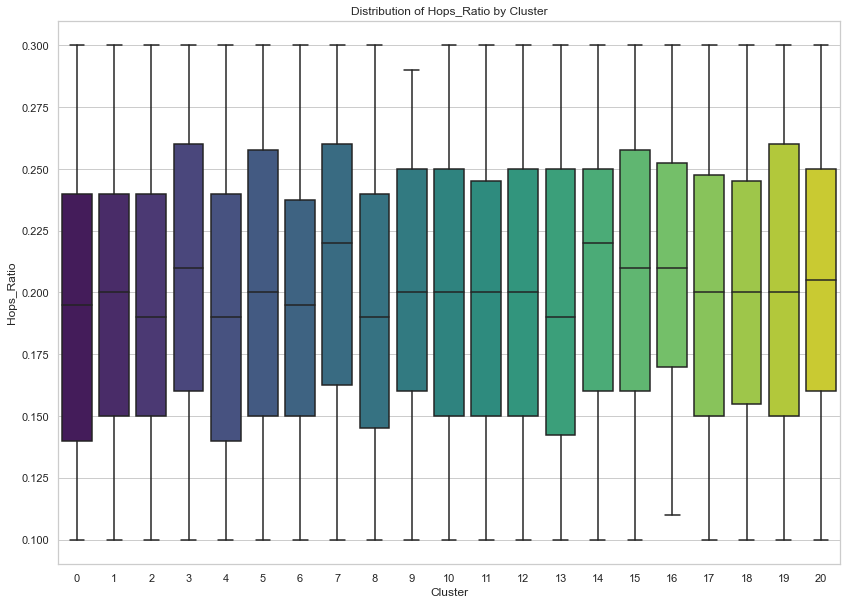

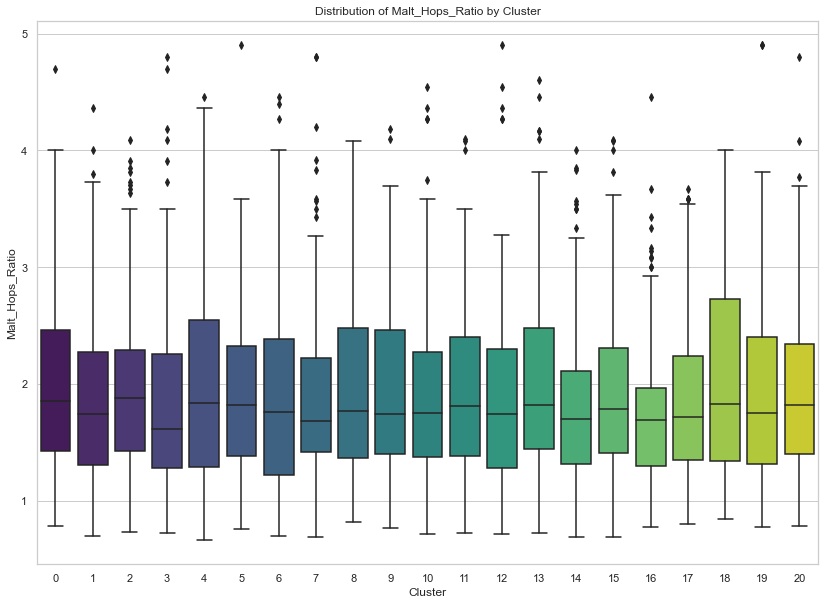

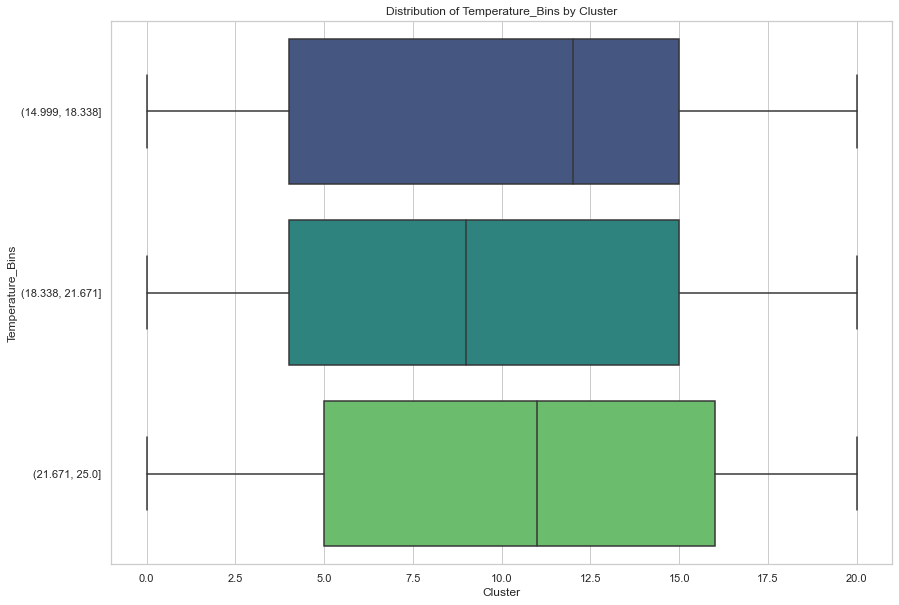

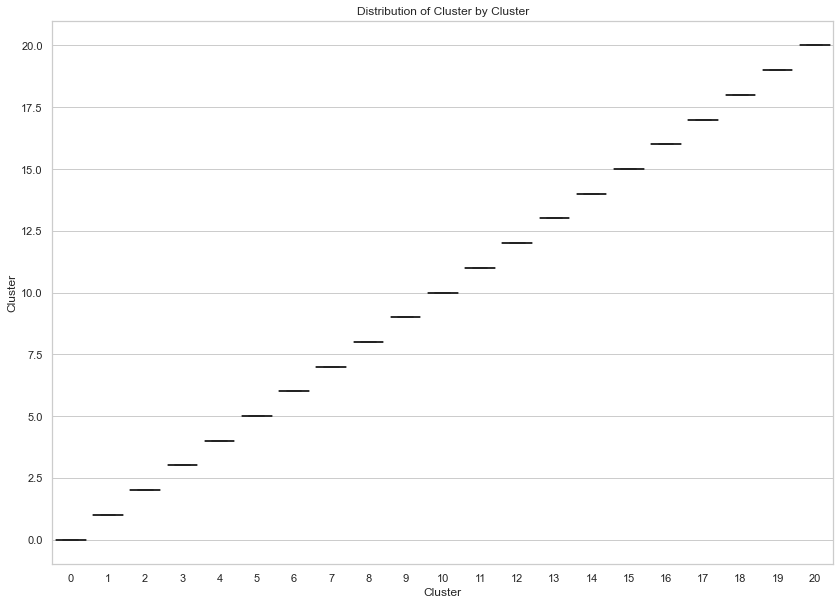

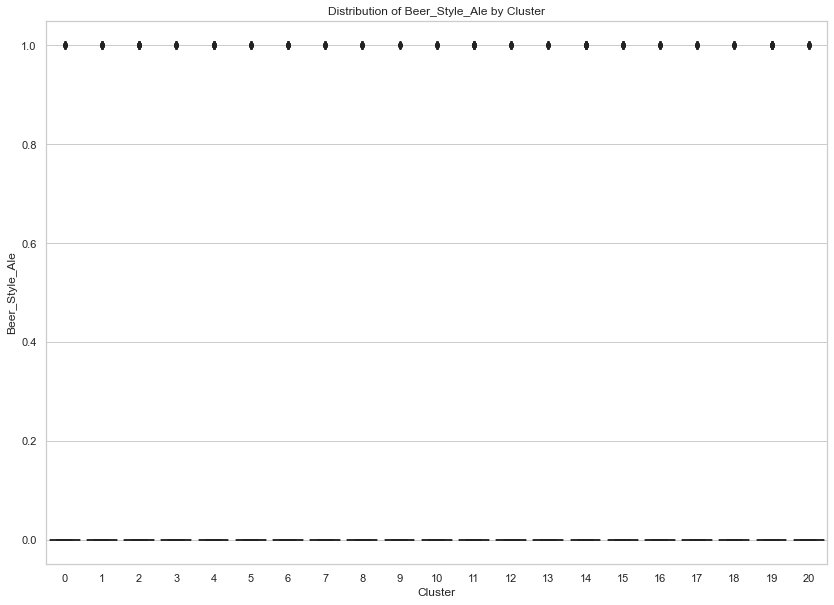

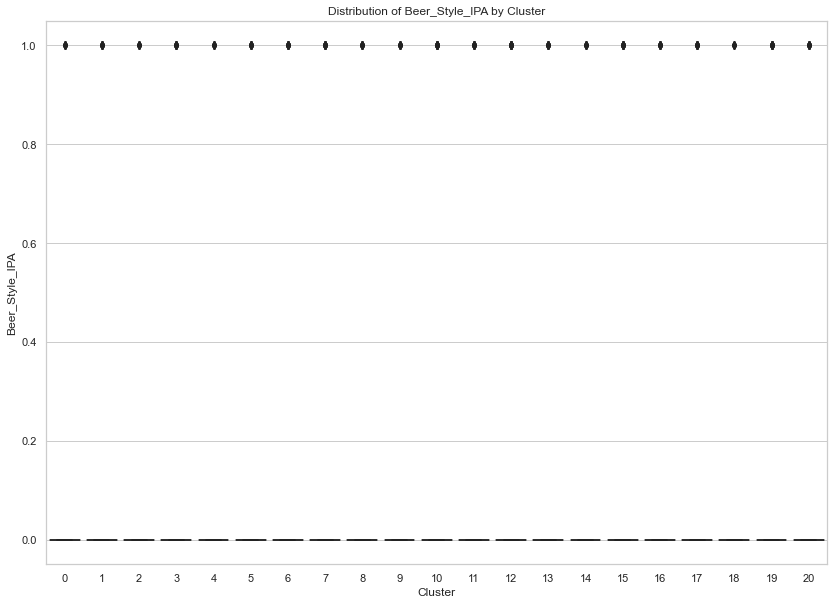

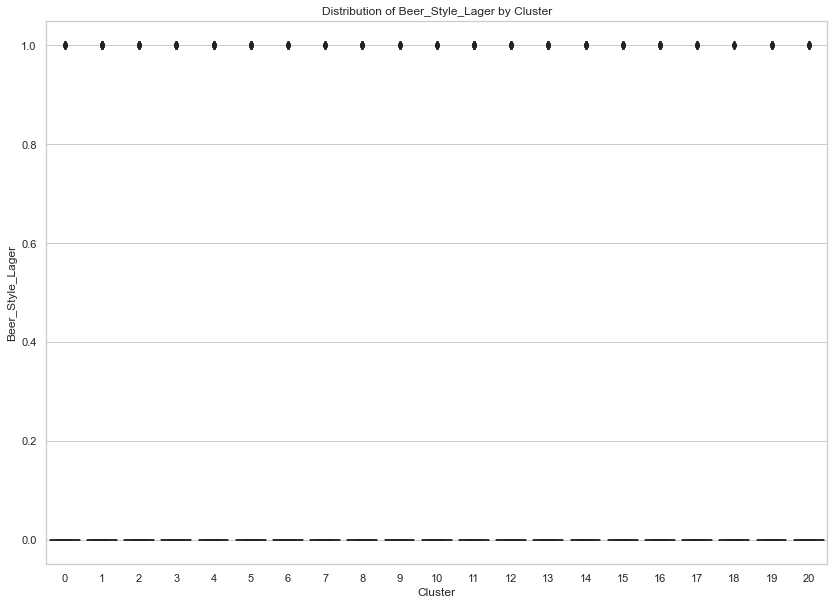

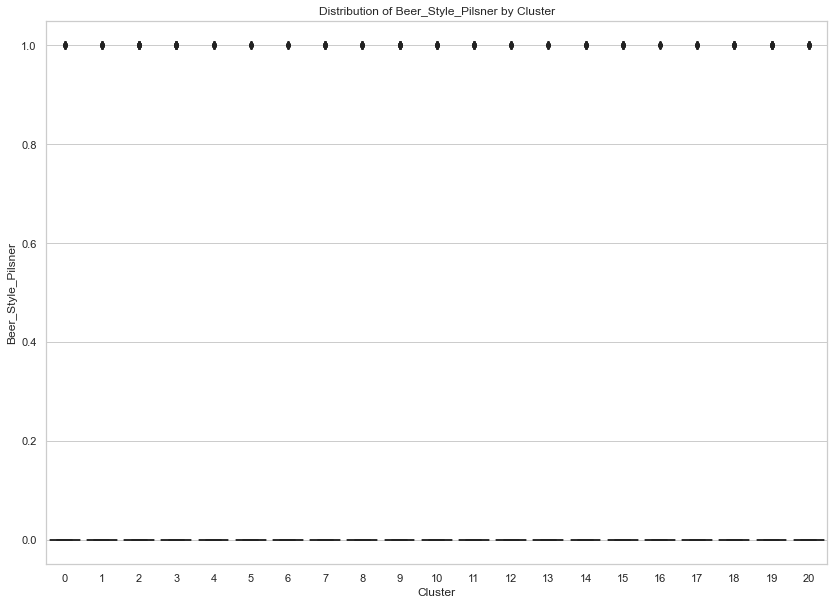

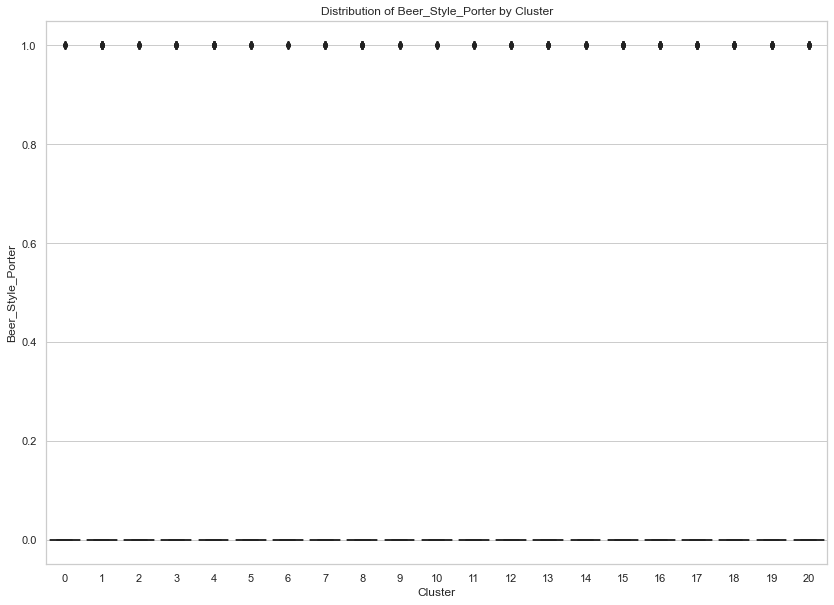

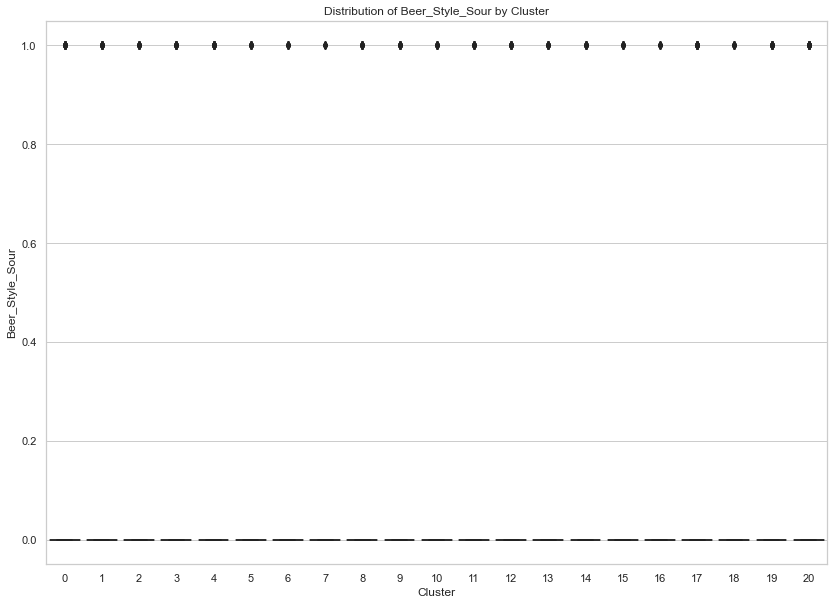

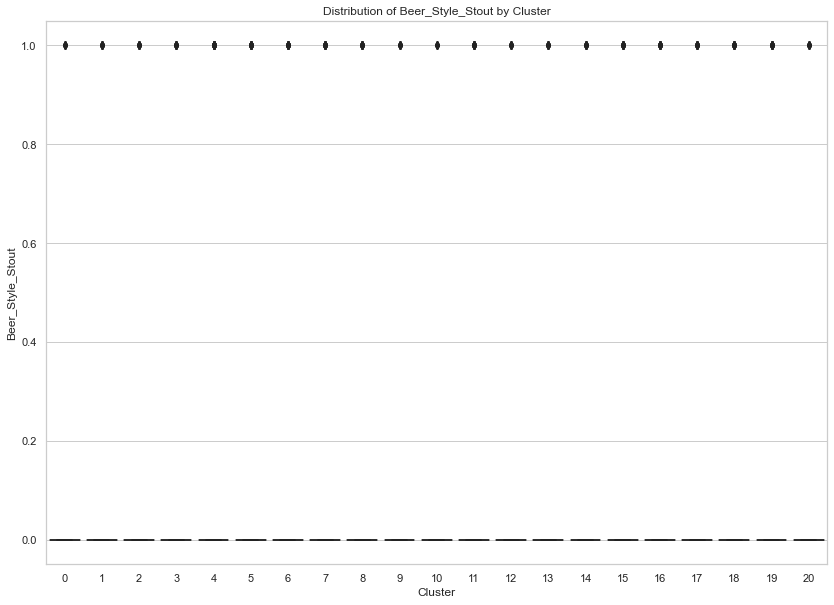

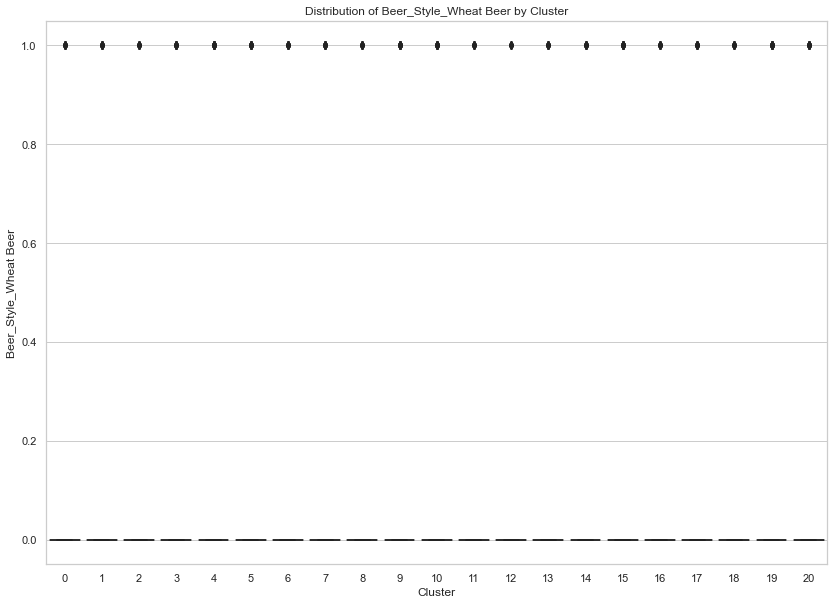

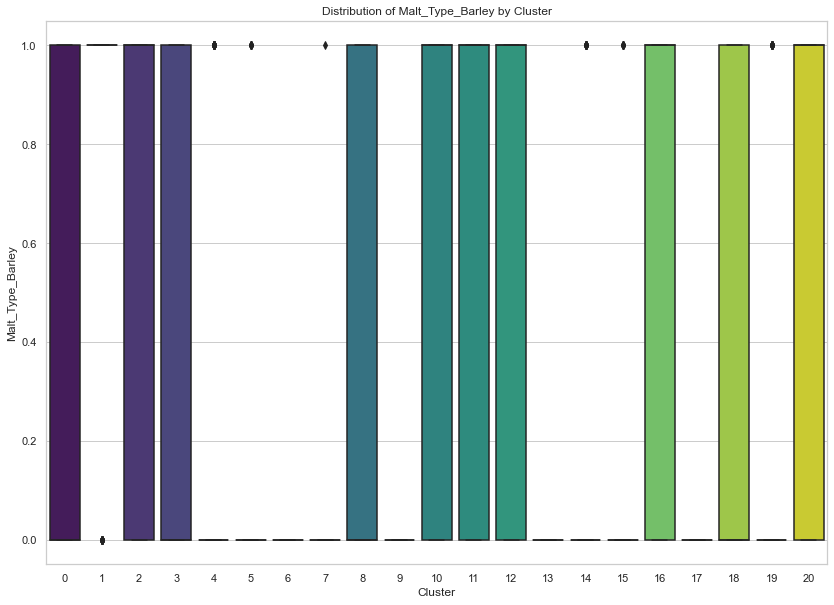

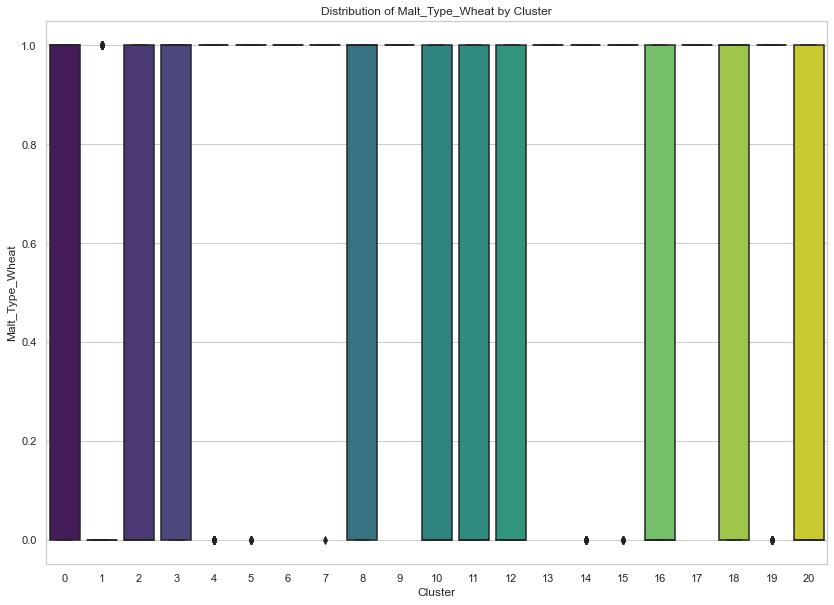

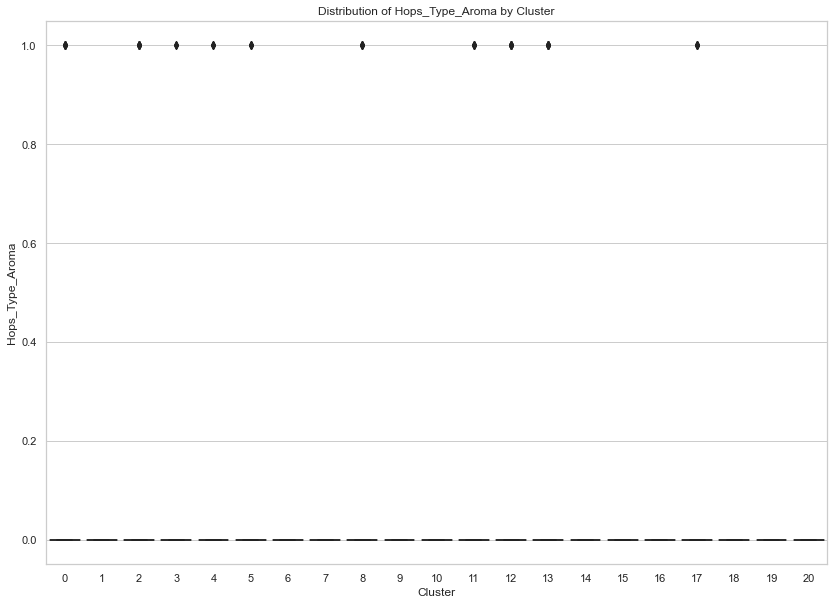

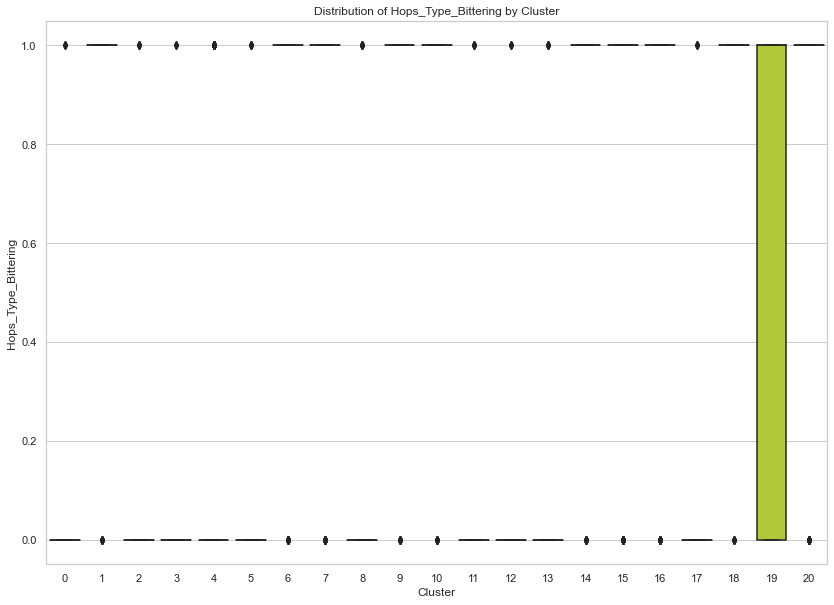

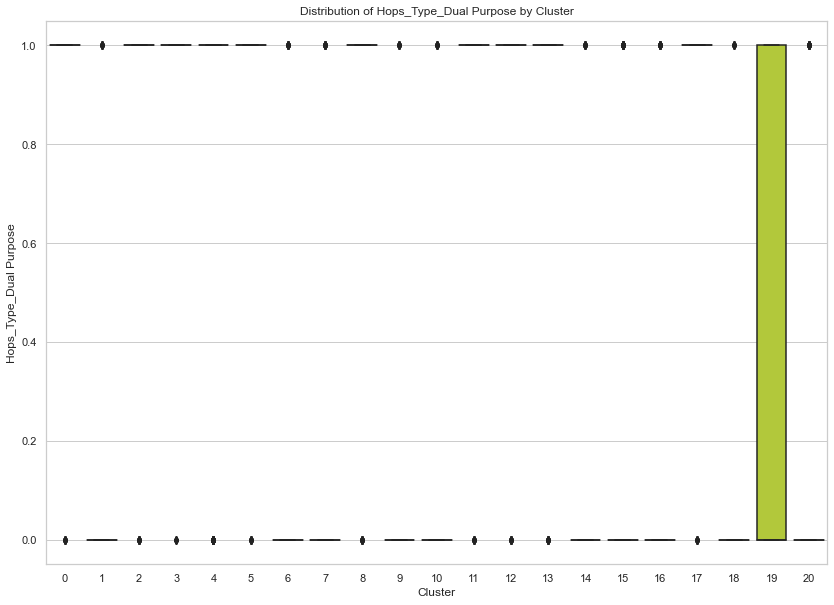

In [34]:
# Step 1: Add cluster information to the DataFrame (already done in the previous step)
# beer_quality_predict['Cluster'] = kmeans.fit_predict(clustering_features_normalized)

# Step 2: Calculate summary statistics
cluster_summary = beer_encoded.groupby('Cluster')

# Display summary statistics
print(cluster_summary)

# Step 3: Visualize distributions

# Box plots for each feature
features_to_plot = beer_encoded.columns.tolist() #['Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

for feature in features_to_plot:
    plt.figure(figsize=(14, 10))
    sns.boxplot(x='Cluster', y=feature, data=beer_encoded, palette='viridis')
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()


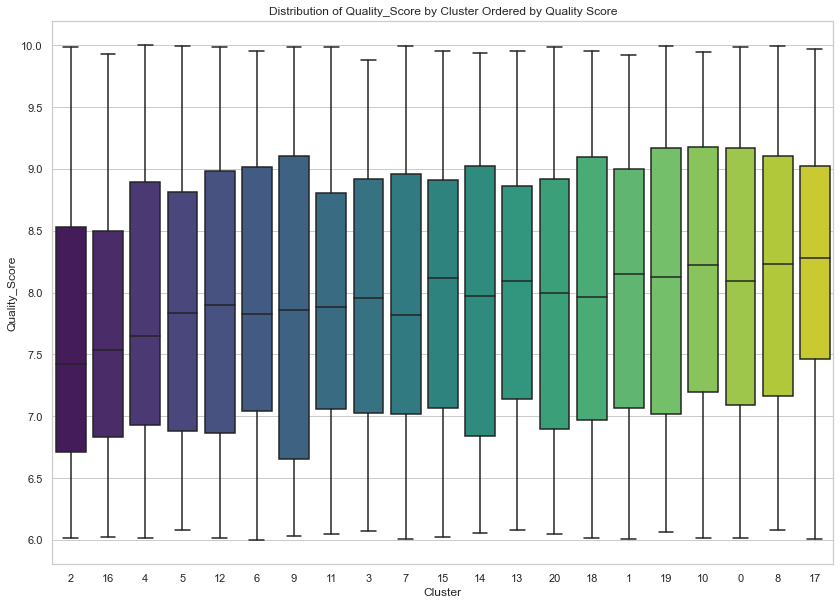

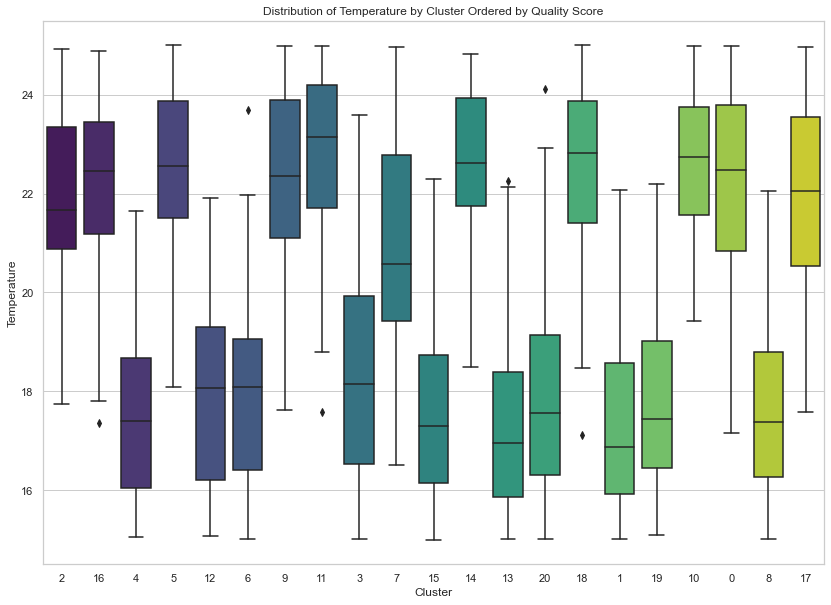

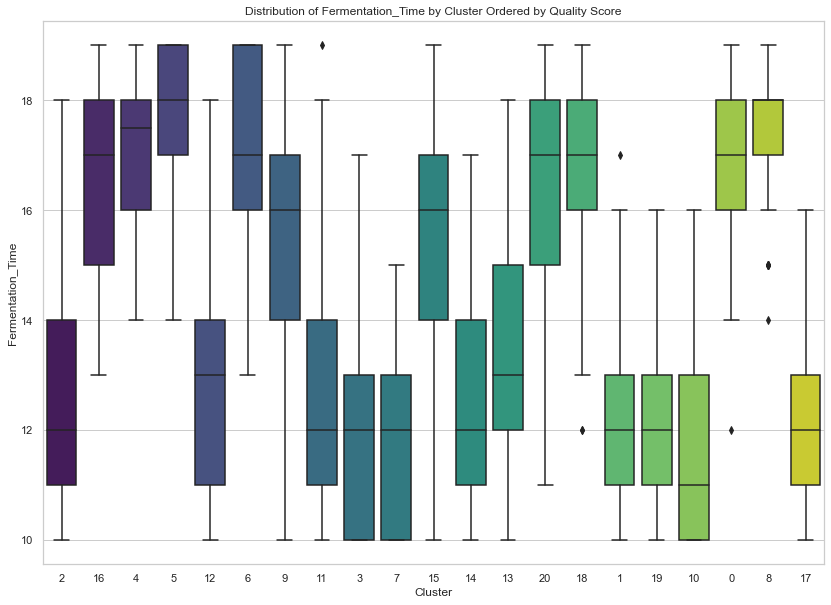

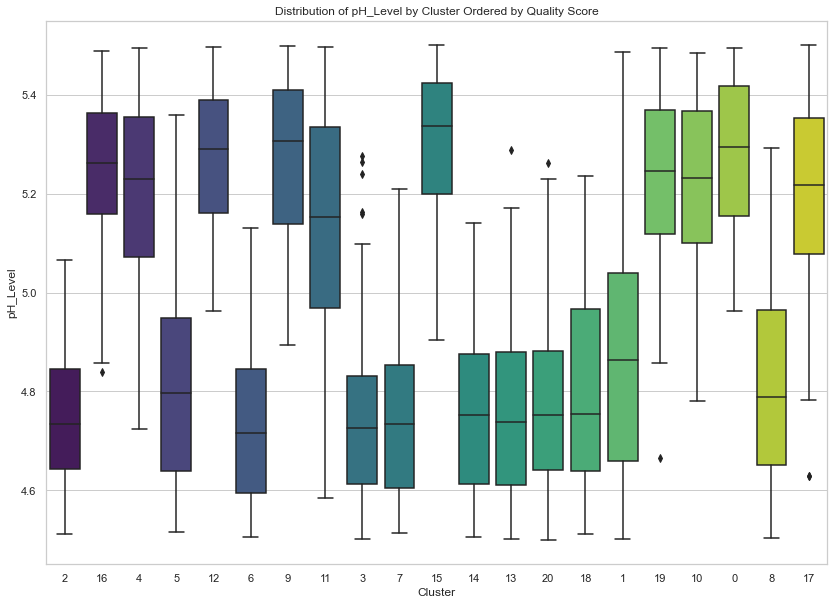

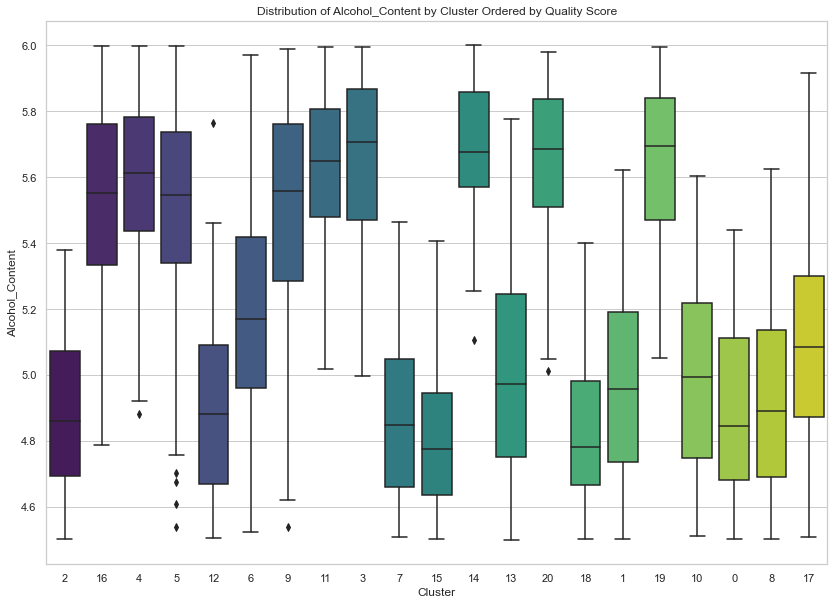

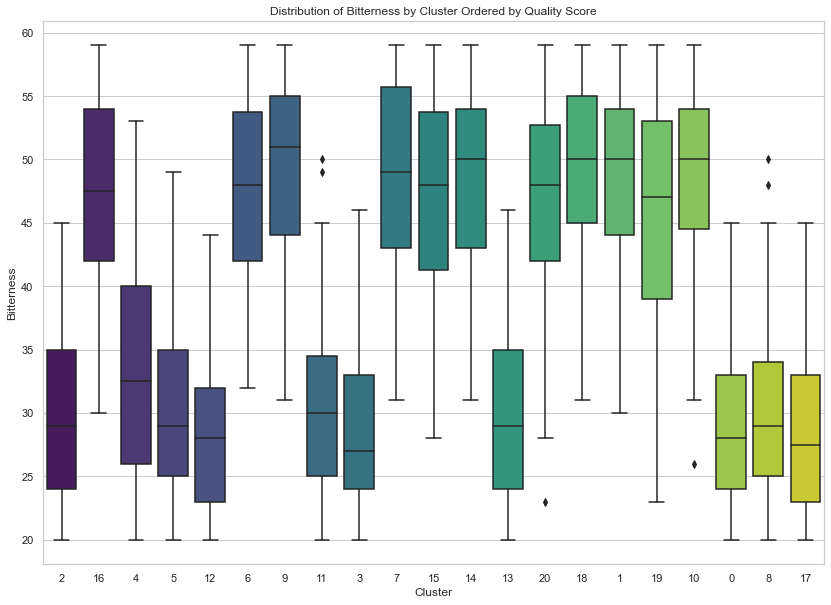

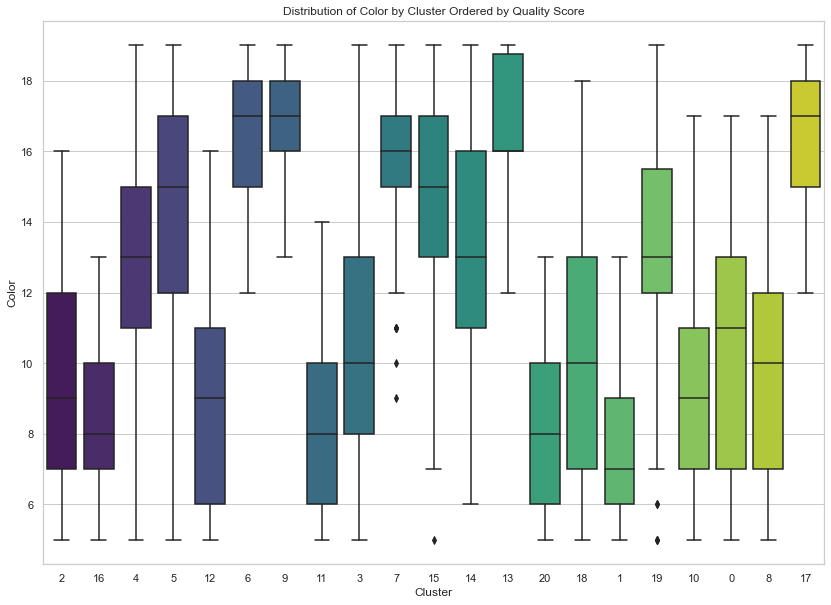

In [40]:
# Step 1: Calculate the average quality score for each cluster
cluster_order = beer_encoded.groupby('Cluster')['Quality_Score'].median().sort_values().index

# Step 2: Convert the 'Cluster' column to a categorical type with the sorted order
beer_encoded['Cluster'] = pd.Categorical(beer_encoded['Cluster'], categories=cluster_order, ordered=True)

# Step 3: Plot the box plots using the ordered clusters
features_to_plot = ['Quality_Score', 'Temperature', 'Fermentation_Time', 'pH_Level', 'Alcohol_Content', 'Bitterness', 'Color']

for feature in features_to_plot:
    plt.figure(figsize=(14, 10))
    sns.boxplot(x='Cluster', y=feature, data=beer_encoded, palette='viridis')
    plt.title(f'Distribution of {feature} by Cluster Ordered by Quality Score')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()


In [ ]:
|# Create 3 quantile-based bins for the Fermentation_Time column
beer_quality_predict['Fermentation_Time_Bins'] = pd.qcut(beer_quality_predict['Fermentation_Time'], q=3)

# Get the value counts for each bin
Fermentation_Time_bin_counts = beer_quality_predict['Fermentation_Time_Bins'].value_counts().sort_index()

# Display the bins and their counts
print("Fermentation_Time Data Ranges with Counts:")
print(Fermentation_Time_bin_counts)


In [ ]:
# One-hot encode categorical variables for machine learning models
beer_encoded = pd.get_dummies(beer_quality_predict, columns=['Beer_Style', 'Malt_Type', 'Hops_Type'])

# Preview the one-hot encoded dataframe
print("One-hot encoded dataframe:")
display(beer_encoded.head())


In [41]:
beer_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 1198923 to 1562165
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   pH_Level                2500 non-null   float64 
 1   Ingredient_Ratio        2500 non-null   object  
 2   Fermentation_Time       2500 non-null   int64   
 3   Temperature             2500 non-null   float64 
 4   Alcohol_Content         2500 non-null   float64 
 5   Bitterness              2500 non-null   int64   
 6   Color                   2500 non-null   int64   
 7   Quality_Score           2500 non-null   float64 
 8   Water_Ratio             2500 non-null   float64 
 9   Malt_Ratio              2500 non-null   float64 
 10  Hops_Ratio              2500 non-null   float64 
 11  Malt_Hops_Ratio         2500 non-null   float64 
 12  Temperature_Bins        2500 non-null   category
 13  Cluster                 2500 non-null   category
 14  Beer_Style_Ale 

In [42]:
# Extracting features (X_sample) and labels (y_sample) 
X_sample = beer_encoded.loc[:, ['Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature', 
                                'Alcohol_Content', 'Bitterness', 'Color', 'Beer_Style_Ale', 'Beer_Style_IPA', 'Beer_Style_Lager', 'Beer_Style_Pilsner', 'Beer_Style_Porter', 'Beer_Style_Sour', 'Beer_Style_Stout', 'Beer_Style_Wheat Beer', 'Malt_Type_Barley', 'Malt_Type_Wheat', 'Hops_Type_Aroma', 'Hops_Type_Bittering', 'Hops_Type_Dual Purpose']]
y_sample = beer_encoded.loc[:, 'Quality_Score']

# X_train and y_train will contain the training data, while X_test and y_test will contain the testing (holdout) data
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Preview the shapes of the training and test sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (2000, 21)
Test set shape: (500, 21)


For another time...
Extracting features (X_sample) and labels (y_sample) 
X_sample = beer_quality_predict.loc[:, 'Malt_Hops_Ratio','Water_Ratio', 'Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature', 
                                'Alcohol_Content', 'Bitterness', 'Color', 'Quality_Score']
y_sample = beer_quality_predict.loc[:, 'Beer_Style']

Splitting the dataset into training and testing sets
X contains features and y contains labels/targets

output is a score not a category, it's numeric so here it's ok to use regression.

Model R^2 score: -0.030557602079099633


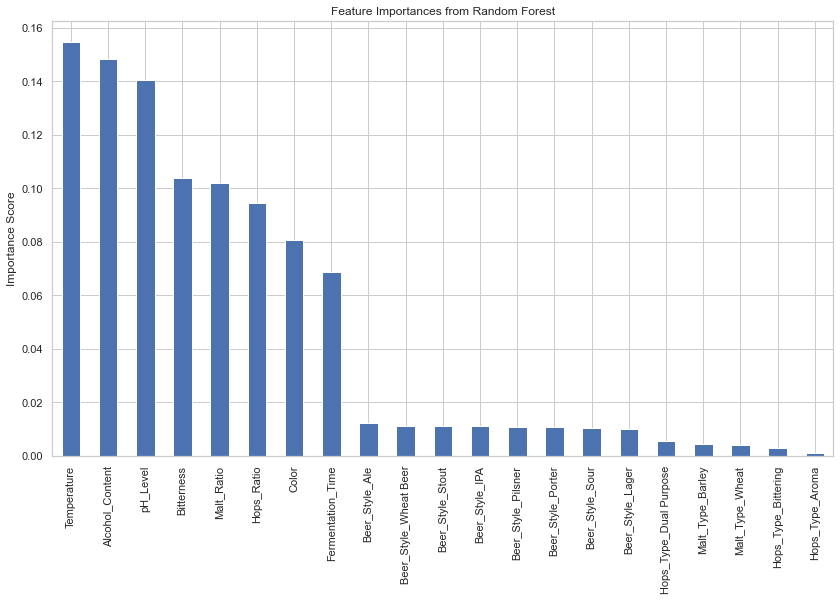

In [44]:
# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Evaluate the model performance
score = rf_model.score(X_test, y_test)
print(f"Model R^2 score: {score}")

# Plot feature importances
plt.figure(figsize=(14, 8))
feature_importances.plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.show()

In [46]:
# Define the parameter grid
param_grid = {
    'n_estimators': [300, 600, 900],
    'max_depth': [None, 10, 40, 80],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Best estimator
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)
r2_score_best = best_rf_model.score(X_test, y_test)
print("R^2 score of the best model:", r2_score_best)


Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 345 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 628 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  4.0min finished


Best parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 900}
R^2 score of the best model: -0.009954002971850562


In [ ]:
# Sample .1% of the rows with a seed for reproducibility
test_beer_quality_predict = beer_quality_predict.sample(frac=0.010, random_state=42)

In [49]:
# beer_encoded is the DataFrame and 'Quality_Score' is the target variable
X_sample = beer_encoded.loc[:, ['Malt_Ratio', 'Hops_Ratio', 'pH_Level', 'Fermentation_Time', 'Temperature', 
                                'Alcohol_Content', 'Bitterness', 'Color', 'Beer_Style_Ale', 'Beer_Style_IPA', 
                                'Beer_Style_Lager', 'Beer_Style_Pilsner', 'Beer_Style_Porter', 'Beer_Style_Sour', 
                                'Beer_Style_Stout', 'Beer_Style_Wheat Beer', 'Malt_Type_Barley', 'Malt_Type_Wheat', 
                                'Hops_Type_Aroma', 'Hops_Type_Bittering', 'Hops_Type_Dual Purpose']]
y_sample = beer_encoded.loc[:, 'Quality_Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model
best_gbr_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_gbr_model.predict(X_test)

# Evaluate the model
r2_score_best = r2_score(y_test, y_pred)
print("R^2 score of the best Gradient Boosting model:", r2_score_best)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 415 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 698 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:   40.8s finished


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}
R^2 score of the best Gradient Boosting model: -0.002006475523663509


In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_encoded.corr()

# Visualize the correlation matrix with the custom SRM colormap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='srm_cmap_custom', fmt='.2f')
plt.title('Correlation Matrix with Custom SRM Colormap')
plt.show()

# Display correlation of features with Quality_Score
quality_corr = correlation_matrix['Quality_Score'].sort_values(ascending=False)
print("Correlation of features with Quality_Score:")
print(quality_corr)


In [ ]:
# Define substances for a simple reaction: Maltose -> 2 Glucose
maltose = Substance.from_formula('C12H22O11')
glucose = Substance.from_formula('C6H12O6')
ethanol = Substance.from_formula('C2H5OH')
co2 = Substance.from_formula('CO2')

# Define a simple reaction: Maltose -> 2 Glucose
reaction = MassAction({'C12H22O11': 1}, {'C6H12O6': 2}, 1.0)

# Get ODE system for the reaction
odesys, extra = get_odesys([reaction])

# Initial concentrations (mol/L)
concs = {maltose: 1.0}

# Time points (seconds)
t = [0, 3600, 7200, 10800]

# Solve the ODEs
result = odesys.integrate(t, concs)

# Plot the results
result.plot(concs.keys())
plt.title("Concentration vs. Time for Maltose to Glucose Reaction")
plt.xlabel("Time (s)")
plt.ylabel("Concentration (mol/L)")
plt.show()


In [ ]:


# Sample DataFrame (replace with actual data)
data = {'Temperature': [16, 19, 22, 23, 25, 18, 13, 10, 8],
        'Fermentation_Time': [5, 10, 4, 12, 3, 7, 9, 14, 10]}
beer_quality_predict = pd.DataFrame(data)

# Function to infer yeast type
def infer_yeast_type(row):
    temperature = row['Temperature']
    fermentation_time = row['Fermentation_Time']
    
    if 17 <= temperature <= 24:
        if 4 <= fermentation_time <= 7:
            return 'Ale'
        elif 1 <= fermentation_time <= 3 or fermentation_time <= 7:
            return 'Wheat/Belgian'
    elif 8 <= temperature <= 14 and fermentation_time >= 8:
        return 'Lager'
    elif 17 <= temperature <= 29:
        if 1 <= fermentation_time <= 3 or fermentation_time <= 7:
            return 'Wheat/Belgian'
    return 'Unknown'

# Apply the function to infer yeast type
beer_quality_predict['Yeast_Type'] = beer_quality_predict.apply(infer_yeast_type, axis=1)

# Display the DataFrame with the inferred yeast type
print(beer_quality_predict)


In [ ]:
#checking to see if the ingredient ratio always starts with 1 (it was)
display(beer_subset['Ingredient_Ratio'].iloc[9000000:9000010])

In [ ]:
#not viable pathway
# Ensure 'Ingredient_Ratio' is numeric
#beer_quality_predict['Ingredient_Ratio'] = pd.to_numeric(beer_quality_predict['Ingredient_Ratio'], errors='coerce')

# Function to estimate initial water pH based on final pH and ingredient buffering capacity
def estimate_initial_ph(final_ph, ingredient_ratio):
    """
    Estimate the initial pH of the water based on the final pH and ingredient ratio.
    
    Parameters:
    - final_ph: The final pH level of the beer.
    - ingredient_ratio: The ratio of different ingredients used in the beer.
    
    Returns:
    - initial_ph: The estimated initial pH of the water.
    """
    # Simplified buffering effect calculation
    buffering_effect = float(ingredient_ratio) * 0.1  # Convert ingredient_ratio to float
    initial_ph = final_ph + buffering_effect
    return initial_ph

# Apply the function to the dataset
beer_quality_predict['Initial_Water_pH'] = beer_quality_predict.apply(lambda row: estimate_initial_ph(row['pH_Level'], row['Ingredient_Ratio']), axis=1)

# Preview the dataset with the new column
print("Dataset with Initial Water pH:")
display(beer_quality_predict[['pH_Level', 'Ingredient_Ratio', 'Initial_Water_pH']].head())


In [ ]:
# Get value counts for each unique value in the Yeast_Type column
yeast_type_counts = beer_quality_predict['Yeast_Type'].value_counts()

# Display the value counts
print(yeast_type_counts)
